<h1 style="text-align:center">PCA-Optimized Wine Data Clustering: An Advanced Analytical Approach to Viniculture Data Stratification</font></h1>  
<h2 style="text-align:center">Sai Sanwariya Narayan</h2>  

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.feature import PCA
from pyspark.sql.functions import mean
import matplotlib.pyplot as plt
import random

In [2]:
spark = SparkSession.builder.appName("PCAExample").getOrCreate()

### Loading the wine clustering data

In [3]:
df_raw = spark.read.csv("/storage/home/ssn5137/Lab10/wine-clustering.csv",header = True, inferSchema=True)
feature_columns = df_raw.columns
print(feature_columns)

['Alcohol', 'Malic_Acid', 'Ash', 'Ash_Alcanity', 'Magnesium', 'Total_Phenols', 'Flavanoids', 'Nonflavanoid_Phenols', 'Proanthocyanins', 'Color_Intensity', 'Hue', 'OD280', 'Proline']


###  Creating a vector-assembler

In [4]:
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
assembled_data = assembler.transform(df_raw)

### Use a StandardScaler to center the data - saved the centered data into a new column called "scaled_features"

In [5]:
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(assembled_data)
scaled_data = scaler_model.transform(assembled_data)

### Print the mean and standard deviation of the centered features

In [6]:
print(scaler_model.mean)

[13.000617977528085,2.336348314606743,2.366516853932584,19.494943820224723,99.74157303370781,2.295112359550562,2.0292696629213474,0.36185393258426946,1.5908988764044947,5.058089882022471,0.9574494382022474,2.6116853932584254,746.8932584269659]


In [7]:
print(scaler_model.std)

[0.811826538005858,1.1171460976144625,0.27434400906081485,3.339563767173504,14.282483515295652,0.6258510488339892,0.9988586850169471,0.12445334029667941,0.5723588626747612,2.318285871822413,0.22857156582982327,0.7099904287650503,314.9074742768492]


### Perform a PCA on the "scaled_features" column, and save the transformed features in "pcaFeatures". Use 10 principal components.

In [8]:
pca = PCA(k=10, inputCol="scaled_features", outputCol="pcaFeatures")
model = pca.fit(scaled_data)
result = model.transform(scaled_data)

### Print how much of the explained variance is captured by 10 principal components

In [9]:
explained_variance = model.explainedVariance
print("Explained Variance: ", sum(explained_variance))

Explained Variance:  0.9616971684450641


### Perform a PCA again in such a way that atleast 90% of the variance is computed

In [10]:
variance_covered = 0
num_components = 0
while variance_covered < 0.9:
    num_components += 1
    pca = PCA(k=num_components, inputCol="scaled_features", outputCol="pcaFeatures")
    model = pca.fit(scaled_data)
    variance_covered = sum(model.explainedVariance)
result = model.transform(scaled_data)
print("Number of principal components covering 90% variance: ", num_components)

Number of principal components covering 90% variance:  8


In [11]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

### Defining a random function for selecting a color

In [12]:
def generate_random_color():
    r = random.random()
    g = random.random()
    b = random.random()
    return (r, g, b)

### Define a Kmeans fit function that can now handle arbitrary columns from an input data frame.

In [13]:
def fit_kmeans(df_input,column_name='pcaFeatures',num_cluster_centers=3):
    '''
    Requires
    df_input: spark dataframe with column name "features" having vector of real-valued inputs
    num_cluster_centers: integer that tells the algorithm the value of k
    column_name: column name (string) that indicates which vector of features to choose
    Returns
    cluster_data: spark dataframe with predictions
    silhouette_score: float with silhouette score
    wcss: float within cluster sum of squares
    '''
    # Create a K-Means instance
    kmeans = KMeans(featuresCol=column_name).setK(num_cluster_centers).setSeed(1)
    
    # Fit the K-Means model to the data
    model = kmeans.fit(df_input)
       
    # Get the cluster assignments for each data point
    clustered_data = model.transform(df_input)

    # Evaluate the clustering using the ClusteringEvaluator
    evaluator = ClusteringEvaluator()
    silhouette_score = evaluator.evaluate(clustered_data)

    # Print the WCSS (Within-Cluster Sum of Squares)
    wcss = model.summary.trainingCost
    
    # Get the cluster sizes and centers
    cluster_sizes = clustered_data.groupBy("prediction").count()
    cluster_sizes.show()
    
    # Return the clustered data
    return clustered_data, silhouette_score, wcss

### Define a visualization function that can color our clusters AND plot the center of the cluster.

In [14]:
# Define a function to perform visualization
def visualize_clusters_2D(clustered_data, feature_1, feature_2,  num_cluster_centers=3):
    '''
    Requires:
    clustered_data: dataframe returned from Kmeans fit
    num_cluster_centers: integer number of clusters
    feature_1: string with identifiers for first column name
    feature_2: string with identifiers for second column name
    '''
    
    # Convert the DataFrame to a Pandas DataFrame for visualization
    pandas_df = clustered_data.select(feature_1, feature_2, "prediction").toPandas()
    
    # Extract the cluster assignments
    cluster_assignments = pandas_df["prediction"]
    
    # Extract the indices for the cluster center
    p1 = feature_columns.index(feature_1)
    p2 = feature_columns.index(feature_2)
    
    # Create a scatter plot for each cluster
    for cluster_id in range(num_cluster_centers):
        # Generate a random color
        random_color = generate_random_color()        
        cluster_data = pandas_df[pandas_df["prediction"] == cluster_id]
        plt.scatter(cluster_data[feature_1], cluster_data[feature_2], color=[random_color], label=f'Cluster {cluster_id}')
        plt.scatter(cluster_data[feature_1].mean(), cluster_data[feature_2].mean(), color=[random_color], marker='x', s=500)
    
    # Set labels and title
    plt.xlabel(feature_1)
    plt.ylabel(feature_2)
    plt.title("K-Means Clustering")
    
    # Show the legend
    plt.legend()
    
    # Display the plot
    plt.show()

### Run a Kmeans fit with 3 clusters using the 'pcaFeatures' column within the 'result' dataframe.

In [15]:
num_centers = 3
clustered_data, _, _ = fit_kmeans(result,column_name='pcaFeatures',num_cluster_centers=num_centers)

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   64|
|         2|   51|
|         0|   63|
+----------+-----+



### Visualize the results of the clustering using pcaFeatures. Pick any two column names for the two axes of the plot (10 points)

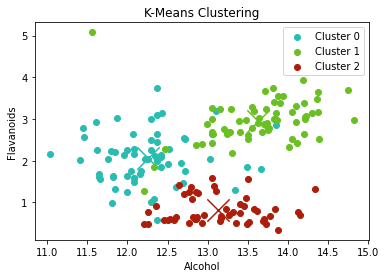

In [16]:
# Convert the DataFrame to a Pandas DataFrame for visualization
feature_1 = "Alcohol"
feature_2 = "Flavanoids"

visualize_clusters_2D(clustered_data, feature_1, feature_2, num_centers)

### Redo the same process but now using the standard 'features' column (similar to Lab 9). Here we will try to compare if the PCA transformed features actually helped with clustering or not (20 points)

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   28|
|         2|   50|
|         0|  100|
+----------+-----+



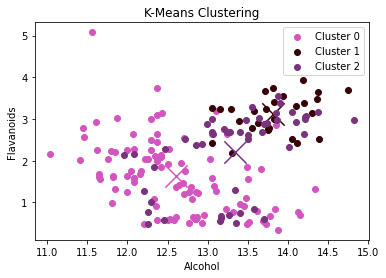

In [17]:
num_centers = 3
clustered_data, _, _ = fit_kmeans(result,column_name='features',num_cluster_centers=num_centers)

# Convert the DataFrame to a Pandas DataFrame for visualization
feature_1 = "Alcohol"
feature_2 = "Flavanoids"

visualize_clusters_2D(clustered_data, feature_1, feature_2, num_centers)


### Which approach to clustering would you prefer? Why?
#### Ans: I would prefer clustering with PCA transformed features. It reduces dimensionality, making computations faster and easier, while retaining most of the variance in the data.

### As in Lab 9 - construct the Elbow and Silhouette curves for the two approaches to clustering. I.e. one using 'pcaFeatures' and the other using 'features'. So you should generate four plots in total. Also comment on what the right value for k must be for the clustering using 'pcaFeatures' (20 points)

In [18]:
def calculate_metrics(df_input, column_name, k_values):
    silhouette_scores = []
    wcss_scores = []

    for k in k_values:
        clustered_data, silhouette_score, wcss = fit_kmeans(df_input, column_name=column_name, num_cluster_centers=k)
        silhouette_scores.append(silhouette_score)
        wcss_scores.append(wcss)

    return silhouette_scores, wcss_scores

In [19]:
k_values = range(2, 11)

# Calculate metrics for pcaFeatures
pca_silhouette_scores, pca_wcss_scores = calculate_metrics(result, 'pcaFeatures', k_values)

# Calculate metrics for features
features_silhouette_scores, features_wcss_scores = calculate_metrics(result, 'features', k_values)

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   91|
|         0|   87|
+----------+-----+

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   64|
|         2|   51|
|         0|   63|
+----------+-----+

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   61|
|         3|    3|
|         2|   51|
|         0|   63|
+----------+-----+

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   57|
|         3|   23|
|         4|   38|
|         2|   50|
|         0|   10|
+----------+-----+

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   27|
|         3|   24|
|         5|   35|
|         4|   23|
|         2|   48|
|         0|   21|
+----------+-----+

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   26|
|         6|    3|
|         3|   34|
|         5|   34|
|         4|   23|
|         2|   49|
|         0|    9|
+----------+-----+

+----------+-----+
|predi

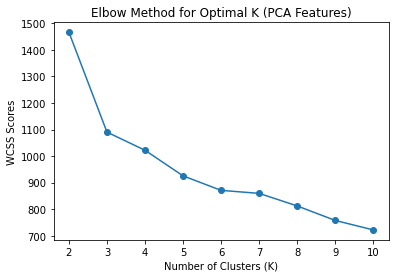

In [24]:
# Plotting the Elbow Method curve for pcaFeatures
plt.figure()
plt.plot(k_values, pca_wcss_scores, marker='o')
plt.title("Elbow Method for Optimal K (PCA Features)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS Scores")
plt.show()

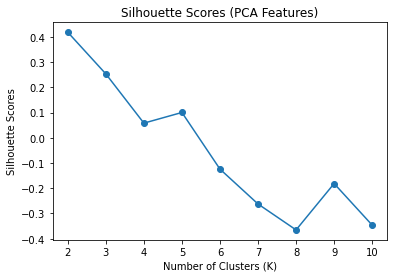

In [25]:
# Plotting the Silhouette curve for pcaFeatures
plt.figure()
plt.plot(k_values, pca_silhouette_scores, marker='o')
plt.title("Silhouette Scores (PCA Features)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Scores")
plt.show()

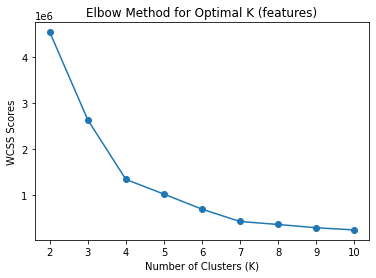

In [26]:
# Plotting the Elbow Method curve for features
plt.figure()
plt.plot(k_values, features_wcss_scores, marker='o')
plt.title("Elbow Method for Optimal K (features)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS Scores")
plt.show()

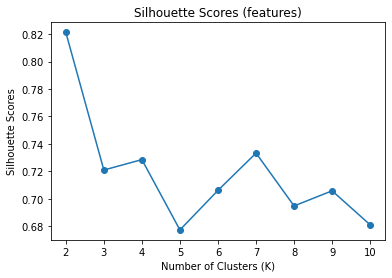

In [27]:
# Plotting the Silhouette curve for features
plt.figure()
plt.plot(k_values, features_silhouette_scores, marker='o')
plt.title("Silhouette Scores (features)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Scores")
plt.show()

# K for pcaFeatures = 3